# Match Lightcone Noise Power to 21cmSense

This notebook is a quick spot-check to make sure that simulating purely thermal noise in a lightcone gives a similar noise power to that predicted by 21cmSense v2 directly.

To make this comparison as closely as possible, we do a few "strange" things. The biggest thing is to make the resolution and size of the lightcone match the UV grid resolution and size automatically chosen by 21cmSense, which is quite coarse. 

The UV resolution chosen by 21cmSense is based on the beam's UV size (at a particular frequency), and this is motivated by the fact that scales smaller than this (in uv) will be highly correlated. 

The UV grid chosen by 21cmSense has a resolution of $\Delta u = D/\lambda$, where $D$ is the dish diameter and $\lambda$ is the wavelength of observation (i.e. each frequency has a different $\Delta u$.
The UV grid chosen by `tuesday` is related instead directly to the LC dimensions. Letting the (transverse) length be $L$ and the number of cells be $N_x$, we have 

$$
    \Delta k = 2\pi/L,
$$

and therefore

\begin{align}
    \Delta u &= \frac{2\pi }{L} \frac{du}{dk}(z) \\
    &= \frac{2\pi }{L} \frac{dL}{d\theta}(z) \frac{1}{2\pi} \\
    &= D_c(z) / L.
\end{align}

Since $D_c$ evolves as $\sim (1+z)^{1/5}$ at high redshifts, clearly this $Delta u$ has a different evolution with frequency than that of 21cmSense, so we shouldn't expect _exact_ correspondence. Instead, we'll just try to align them in the central redshift of the lightcone.

Another thing here is that in 21cmSense, the line-of-sight is in equally-spaced bins of *frequency* instead of comoving distance (which is the case for `tuesday` lightcones). 
To at least get some correspondence, we set the redshift range of the lightcone to be the same as the bandwidth for 21cmSense. 

To get a decent power spectrum out, with a number of k bins, we need a decent frequency resolution, but the resolution over the line of sight in the lightcone is forced to be the same as the transverse direction. So, let's say we have 12 MHz of bandwidth, at $\Delta \nu = 200$ kHz resolution, then $\Delta x_{\rm los}$ at the centre is 

$$ 
    \Delta x_{\rm los} = D_c\left(\frac{1 + \bar{z}}{1 + \Delta \nu (1 + \bar{z})/1420{\rm MHz}} - 1\right) - Dc(\bar{z}).
$$

This means that we must use $N_x = L / \Delta x_{\rm los}$, which will give us our maximum value of $u$:

\begin{align}
    u_{\rm max} &= k_{\perp, \rm max} \frac{du}{dk_{\rm perp}}(\bar{z}) \\
    &= \frac{D_c(\bar{z})}{\Delta x_{\rm los}} \\
    &= \frac{D_c(\bar{z})}{ D_c\left(\frac{1 + \bar{z}}{1 + \Delta \nu (1 + \bar{z})/1420{\rm MHz}}\right) - Dc(\bar{z})}
\end{align}

**TODO:**

* Maybe off by a little in the uv grid (edges vs centres?)
* Central pixel should be zero?
* Inverse variance weighting on the angular average? (tuesday -> powerbox)
* Test whether applying inverse variance weighting to fourier modes directly is the same as applying inverse variance weighting to angular averaging at pspec time.



In [1]:
import astropy.units as un
import matplotlib.pyplot as plt
import numpy as np
from astropy import cosmology as csm
from astropy.cosmology import Planck18, z_at_value
from astropy.cosmology import units as cu
from py21cmsense import Observation, Observatory
from py21cmsense.conversions import f2z, z2f

from tuesday.core import (
    compute_thermal_rms_uvgrid,
    sample_from_rms_uvgrid,
)

In [2]:
csm.default_cosmology.set(Planck18)
un.add_enabled_units(cu);

## Set observation parameters

First, we set our observational parameters for use in 21cmSense. We use an SKA AA4 layout, but only the core, just for testing purposes. 
Everything else here is set essentially arbitrarily (we will use these values later to set the lightcone parameters consistently, but
we are basically free to choose here). We use a long integration time giving only two integrations in the whole tracked scan, just so that
the code runs more quickly.

In [3]:
hours_tracking = 1.0 * un.hour
integration_time = 1800 * un.s

zmean = 15.0
freq = 1420 / (1 + zmean) * un.MHz

observatory = Observatory.from_ska(subarray_template="LOW_INNER_R350M_AA4")

# Set the correct frequency
observatory = observatory.clone(beam=observatory.beam.clone(frequency=freq))

# Make an observation
observation = Observation(
    observatory=observatory,
    time_per_day=hours_tracking,
    lst_bin_size=hours_tracking,
    integration_time=integration_time,
    bandwidth=26.3 * un.MHz,
    n_channels=80,  # 200 kHz channels
    n_days=int(np.ceil(1000 / hours_tracking.value)),
    tsky_amplitude=60.0 * un.K,  # to be consistent with tools21cm
    tsky_ref_freq=300.0 * un.MHz,
    spectral_index=2.55,
)

/home/sgm/.local/share/uv/python/cpython-3.12.6-linux-x86_64-gnu/lib/python3.12/abc.py:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


Now, let's setup the lightcone to "exactly" match the 21cmSense calculation's resolutions:

In [ ]:
# Setup some fake frequencies, similar to a standard observation,
# but regular in comoving distance, like a typical simulation.

min_freq = freq - observation.bandwidth / 2
max_freq = freq + observation.bandwidth / 2
min_z = f2z(max_freq)  # lower edge of first cell
max_z = f2z(min_freq)  # upper edge of last cell

Dz = Planck18.comoving_distance(zmean)

# By equating the Delta u between 21cmSense and Tuesday LC,
# we can compute L:
boxlength = Dz / observatory.beam.uv_resolution

# By equating the frequency channel width we can get the box resolution:
nuprime = freq - observation.bandwidth / observation.n_channels
zprime = f2z(nuprime)
boxres = Planck18.comoving_distance(zprime) - Dz
box_ncell = int(boxlength / boxres)

# Now, we actually want the same *number* of channels as the observation,
# where each has the same comoving size, and this comoving size is given
# by boxres. This will actually mean that the total length of the box
# along the line of sight is larger than the the bandwidth of the observation,
# because channels tend to get smaller in comoving size.
min_dist = Dz - boxres * observation.n_channels / 2
max_dist = Dz + boxres * observation.n_channels / 2

distances = (
    np.arange(
        min_dist.to_value("Mpc"), max_dist.to_value("Mpc"), boxres.to_value("Mpc")
    )
    * un.Mpc
)
nz = len(distances)

lc_redshifts = np.array([z_at_value(Planck18.comoving_distance, d) for d in distances])
lc_freqs = z2f(lc_redshifts)

lc_shape = (box_ncell, box_ncell, nz)

In [ ]:
print(f"Lightcone shape: {lc_shape}")
print(f"Lightcone size (cMpc): {boxlength, boxlength, max_dist - min_dist}")
print(
    "Observation bandwidth size (cMpc): "
    f"{Planck18.comoving_distance(max_z) - Planck18.comoving_distance(min_z)}"
)

Lightcone shape: (117, 117, 80)
Lightcone size (cMpc): (<Quantity 929.19413703 Mpc>, <Quantity 929.19413703 Mpc>, <Quantity 632.9256058 Mpc>)
Observation bandwidth size (cMpc): 588.7086695297712 Mpc


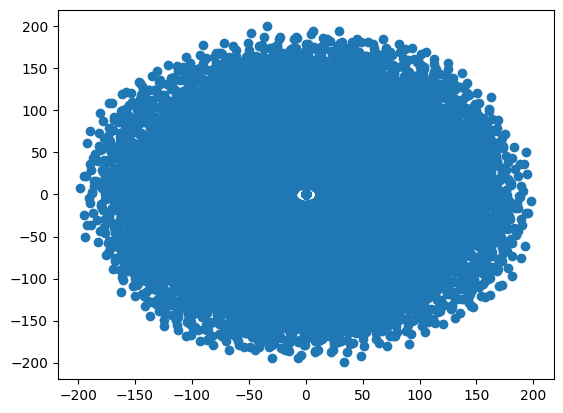

In [6]:
plt.scatter(
    observatory.baselines_metres[:, :, 0].flatten() / observatory.beam.wavelength,
    observatory.baselines_metres[:, :, 1].flatten() / observatory.beam.wavelength,
)

## Compute thermal noise RMS

In [7]:
ugrid_edges, sigma_uv, uv_coverage = compute_thermal_rms_uvgrid(
    observation=observation, freqs=lc_freqs, box_length=boxlength, box_ncells=box_ncell
)

finding redundancies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 649.57ants/s]
/home/sgm/work/21cmfast/tuesday/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Now, plot the UV coverage of Tuesday versus 21cmSense.

These should have the same resolution (almost) and UV grid, however Tuesday will extend to much large UV values, which will be empty, because the $\Delta x$ is set by the line-of-sight rather than the UV grid.

An important note is that we divide the 21cmSense UV coverage by two here because in 21cmSense we add all mirror baselines but _don't_ renormalize the UV counts (instead later we just discard the mirror baselines when computing the sensitivity). In Tuesday we compute the mirror baselines but halve the contribution of each. 

First, let's check the uvgrid of each:

In [ ]:
chan = observation.n_channels // 2
print(f"du for tuesday: {ugrid_edges[1, chan] - ugrid_edges[0, chan]}")
print(f"du for sense: {observation.ugrid_edges[1] - observation.ugrid_edges[0]}")

du for tuesday: 11.265273125509793


finding redundancies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 3385.44ants/s]

du for sense: 11.249449110557663


In [9]:
print(f"Number of ugrid points for sense: {len(observation.ugrid_edges)}")
print(f"Number of ugrid points for tuesday: {len(ugrid_edges[:, 0])}")

Number of ugrid points for sense: 38
Number of ugrid points for tuesday: 118


In [ ]:
_ui = lc_shape[0] // 2
print(f"Central pixels for tuesday: {ugrid_edges[_ui - 5 : _ui + 5, chan]}")
_nu = len(observation.ugrid_edges)
print(
    "Central pixels for sense: "
    f"{observation.ugrid_edges[_nu // 2 - 5 - 1 : _nu // 2 + 5 - 1]}"
)

Central pixels for tuesday: [-61.95900219 -50.69372906 -39.42845594 -28.16318281 -16.89790969
  -5.63263656   5.63263656  16.89790969  28.16318281  39.42845594]
Central pixels for sense: [-61.87197011 -50.622521   -39.37307189 -28.12362278 -16.87417367
  -5.62472456   5.62472456  16.87417367  28.12362278  39.37307189]


Text(0.5, 1.0, 'uvcov sense')

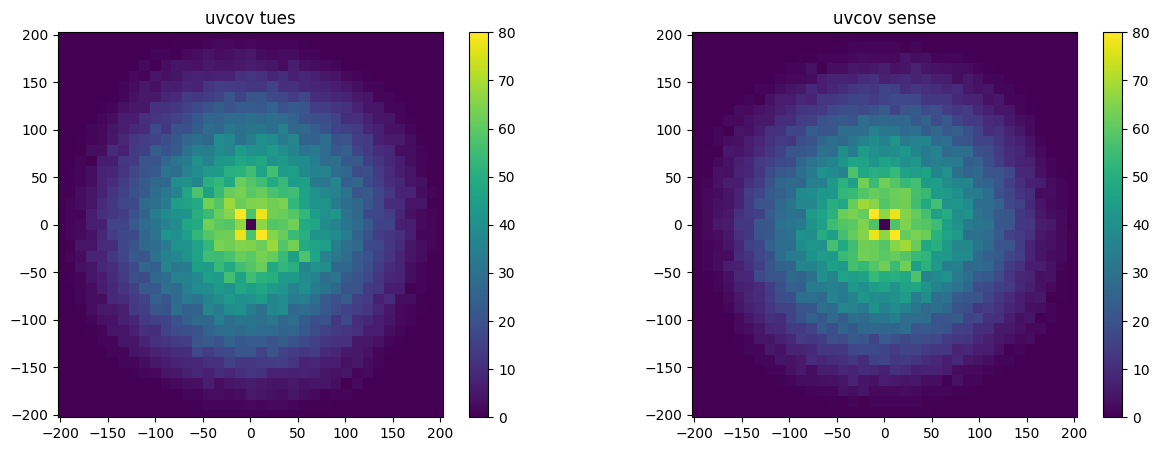

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ugrid = (ugrid_edges[1:] + ugrid_edges[:-1]) / 2
chan = observation.n_channels // 2
im = ax[0].imshow(
    uv_coverage[:, :, chan].T,
    extent=(ugrid[0, chan], ugrid[-1, chan]) * 2,
    origin="lower",
)
ax[0].set_xlim(observation.ugrid[0], observation.ugrid[-1])
ax[0].set_ylim(observation.ugrid[0], observation.ugrid[-1])

plt.colorbar(im, ax=ax[0])

ax[0].set_title("uvcov tues")

im = ax[1].imshow(
    (observation.uv_coverage / 2).T,
    extent=(observation.ugrid[0], observation.ugrid[-1]) * 2,
    origin="lower",
)
ax[1].set_xlim(observation.ugrid[0], observation.ugrid[-1])
ax[1].set_ylim(observation.ugrid[0], observation.ugrid[-1])

plt.colorbar(im, ax=ax[1])
ax[1].set_title("uvcov sense")

These are not exactly the same, but they are pretty close. One of the differences seems to be that 21cmSense is symmetric but tuesday is not. This will be a problem actually. We can check the total number of points:

In [12]:
print("Total number of uv points in tuesday:", np.sum(uv_coverage[:, :, chan]))
print("Total number of uv points in sense:", np.sum(observation.uv_coverage / 2))

Total number of uv points in tuesday: 20296.0
Total number of uv points in sense: 20296.0


# Sample lightcone noise with `tuesday`
With `tuesday` we can control the random generation by setting a random seed manually for reproducibility. If not set, a seed is chosen at random.\
We can also set the number of noise realisations we want with `nsamples`.\
`sample_from_rms_noise` takes as input the thermal noise in uv space that we plotted above and returns only samples of the noise in real or Fourier space.
On the other hand, the `sample_lc_noise` convenience function does the entire noise calculation given an `Observation` and a `lightcone` and returns samples of noisy lightcones, where realisations of thermal noise have been added in Fourier space as in Prelogovic+23.

In [ ]:
lc_noise = sample_from_rms_uvgrid(
    rms_noise=sigma_uv,
    seed=4,
    nsamples=1,
    window_fnc="boxcar",
    return_in_uv=False,
)

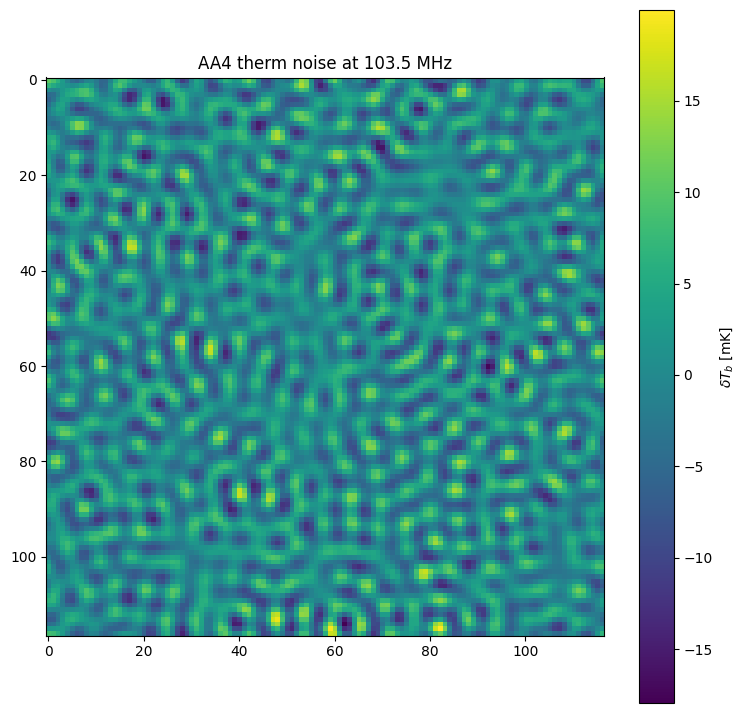

In [14]:
plt.figure(figsize=(9, 9))
im = plt.imshow(lc_noise[0, ..., 0].real.value)
plt.colorbar(im, label=r"$\delta T_b$ [mK]")
plt.title(f"AA4 therm noise at {np.round(lc_freqs[0].to_value('MHz'), 1)} MHz")
plt.show()

Note that the wormy pattern here is due to lack of long baselines (no UV coverage outside the inner circle) which means no small scale structure.

## Calculate the theoretical noise power from 21cmsense

In [ ]:
from py21cmsense.sensitivity import PowerSpectrum

sense = PowerSpectrum(
    observation=observation,
    foreground_model="foreground_free",
)
sense1d_thermal = sense.calculate_sensitivity_1d(thermal=True, sample=False)

averaging to 1D: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 125.27kperp-bins/s]


## Calculate the noise power from realization

/home/sgm/work/21cmfast/tuesday/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


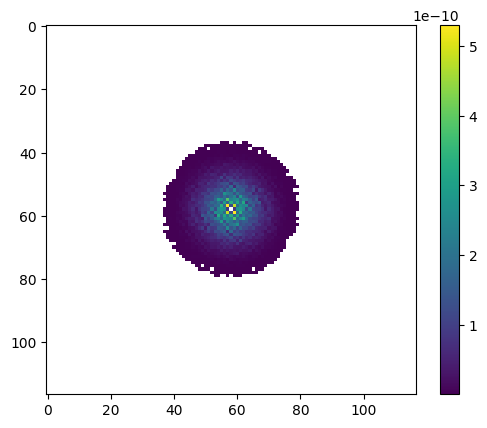

In [16]:
plt.imshow(1 / sigma_uv[:, :, 0] ** 4)
plt.colorbar()

In [18]:
from tuesday.core import calculate_ps_lc, plot_power_spectrum

dk = sense.k1d[1] - sense.k1d[0]

weights = np.where(sigma_uv > 0, 1 / sigma_uv**4, 0)

ps1d, ps2d = calculate_ps_lc(
    lc_noise[0],
    lc_redshifts=lc_redshifts,
    box_length=boxlength,
    calc_2d=True,
    calc_1d=True,
    deltasq=True,
    chunk_indices=[(0, nz)],
    k_weights_1d=weights,
    k_weights_2d=weights,
    k_bins=np.concatenate(
        (
            (sense.k1d - dk).to("1/Mpc", cu.with_H0()).value,
            [(sense.k1d[-1] + dk).to("1/Mpc", cu.with_H0()).value],
        )
    ),
)

outshape:  (80,)
actual outshape:  (53, 80)


/home/sgm/work/21cmfast/tuesday/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/sgm/work/tools/powerbox/src/powerbox/tools.py:731: UserWarning: One or more radial bins had no cells within it.
  avg, _bins, variance, sumwght = angular_average(
/home/sgm/work/tools/powerbox/src/powerbox/tools.py:693: UserWarning: One or more radial bins had no cells within it.
  return angular_average(


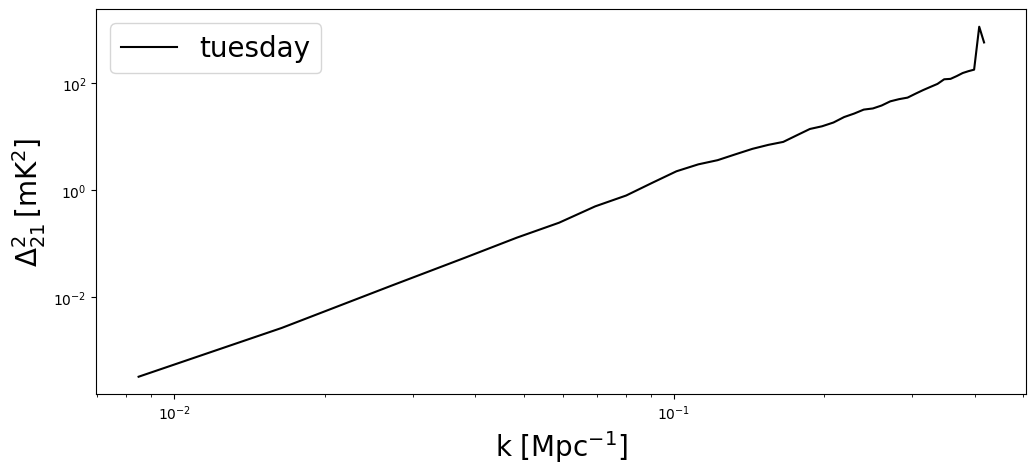

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax = plot_power_spectrum(
    ps1d[0],
    fontsize=20,
    ax=ax,
    color="k",
    legend="tuesday",
    logx=True,
    logy=True,
)

/home/sgm/work/21cmfast/tuesday/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:1890: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)


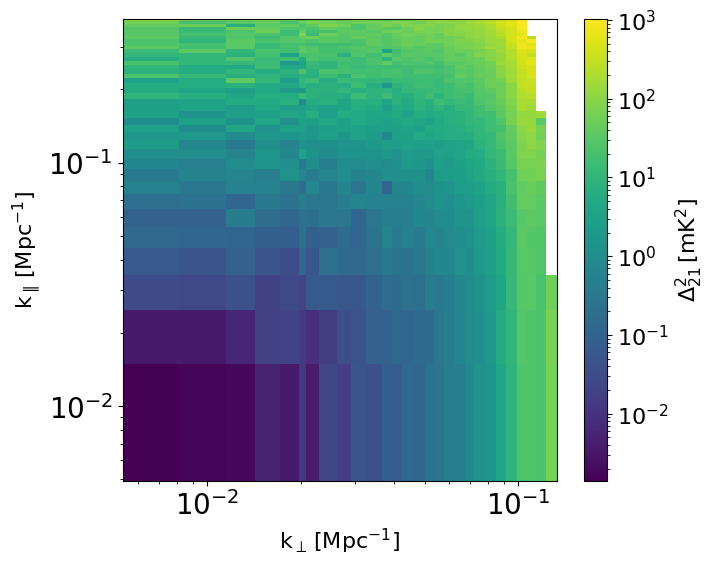

In [20]:
ax = plot_power_spectrum(
    ps2d[0],
    logx=True,
    logy=True,
    logc=True,
)

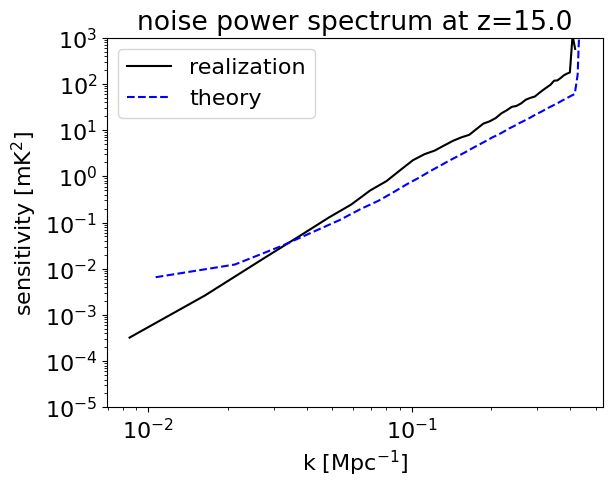

In [21]:
plt.plot(
    ps1d[0].k.to("1/Mpc", cu.with_H0()),
    ps1d[0].ps,
    label="realization",
    color="black",
)
plt.loglog()
plt.xlabel(r"k [Mpc$^{-1}$]")
plt.ylabel(r"sensitivity [mK$^2$]")

plt.plot(
    sense.k1d.to("1/Mpc", cu.with_H0()),
    sense1d_thermal.value,
    label="theory",
    color="b",
    ls="--",
)
plt.ylim(1e-5, 1e3)
plt.loglog()
plt.title(f"noise power spectrum at z={zmean}")
plt.legend()